# Homework 2

MBA200A: Data Analytics

UC Berkeley Haas School of Business


## Question 1: Load and prep the data
Load the diamond dataset as well as any packages you may need to run regressions or fit a Lasso model. Call the dataset "Diamonds". The diamond dataset can be found on bcourses and is listed as Diamond_sample.csv. Remember to omit the missing values. If you are having trouble remembering the packages you need, refer to Labs 1 and 2. 

In [8]:
library(ggplot2)
library(dplyr)
library(glmnet)
library(stats)

dataSet<- read.csv('Diamonds_sample.csv', header = TRUE, stringsAsFactors = TRUE)

Print the first few lines of the data so you can get a sense for the structure, also calculate the average cost of a diamond.

In [9]:
head(dataSet)
summary(dataSet["cost"])
print("Average cost is 3266")

,GEM_ID,carat,clarity,high_color,cut,cost
,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,47129,0.2746253,1,1,1,3468.159
2,26282,0.4699232,1,1,1,4814.552
3,25473,0.6673995,1,1,1,6473.046
4,15093,0.4628467,1,1,1,2992.616
5,83048,0.5830976,1,0,1,5471.689
6,22707,0.4277917,1,1,1,3999.953


      cost      
 Min.   :-1473  
 1st Qu.: 2184  
 Median : 3229  
 Mean   : 3266  
 3rd Qu.: 4295  
 Max.   : 8556  

[1] "Average cost is 3266"


To run Lasso, we need to prep our data properly. The package we are using, glmnet, requires that we input the data as matrices (the lm command we were using last week was doing this for us). The outcome we are interested in predicting is the price of a diamond.

We won't need the GEM_ID variable for our analysis. Create a new dataset that contains all the other variables using the ``c()`` function and method we learned in lab 1. We will use this dataset going forward. 

Define the outcome as ``cost`` and x matrix using the ``model.matrix( )`` function.

In [10]:
variables = c("carat", "clarity", "high_color", "cut", "cost")
dataSet = dataSet[variables]

x = model.matrix(cost~., dataSet)[,-1]
head(x)

y = dataSet$cost

,carat,clarity,high_color,cut
1,0.2746253,1,1,1
2,0.4699232,1,1,1
3,0.6673995,1,1,1
4,0.4628467,1,1,1
5,0.5830976,1,0,1
6,0.4277917,1,1,1


To evaluate the performance of our model, we need to divide the data into training and testing data. We will train the model on the training data and evaluate it on the testing data. 

Split the data evenly into train and test datasets. Set the seed to 555 and use the command ``sample()`` to select which observations go into the training dataset. This is the same procedure we used in Lab 2, and it's necessary in order to get results that match the official solutions. If you do not set the seed to 555 you may not end up with the exact solutions required in the bcourses quiz.

**Important:**
Set the seed equal to 555 before you run ``sample()``.

In [11]:
set.seed(555)

# Assign training sample randomly
train_row <- sample(1:nrow(x),nrow(x)/2)
y_train <- y[train_row]
x_train <- x[train_row,]

# Assign leftover to test sample
y_test <- y[-train_row]
x_test <- x[-train_row,]


## Question 2: Lasso

Now create a Lasso model with the data using ``glmnet()``. Remember you do not need to specify lambda, the command is going to test many values for you. Plot the Lasso model 

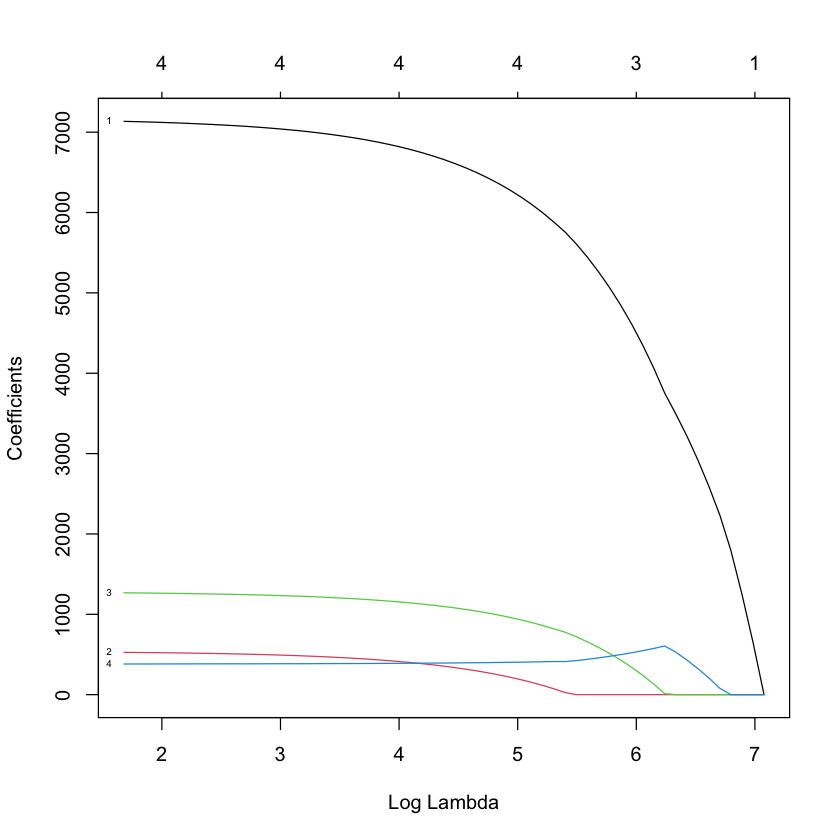

In [12]:
# Fit to full dataset with chosen lambda, examine coefficients
lasso_train <- glmnet(x_train, y_train, alpha=1)

# See coefficients by lambda
plot(lasso_train, xvar = "lambda", label = TRUE)

Select the optimal lambda for a Lasso model using cross-validation command (``cv.glmnet()``), based on the the lambda that produce the best $R^2$ (see Lab 2 if you don't remember how to define $R^2$). Use the option ``nfolds=10`` (the default). Print the optimal lambda. 

**Important:**
Set the seed equal to 555 before you run ``cv.glmnet()``.

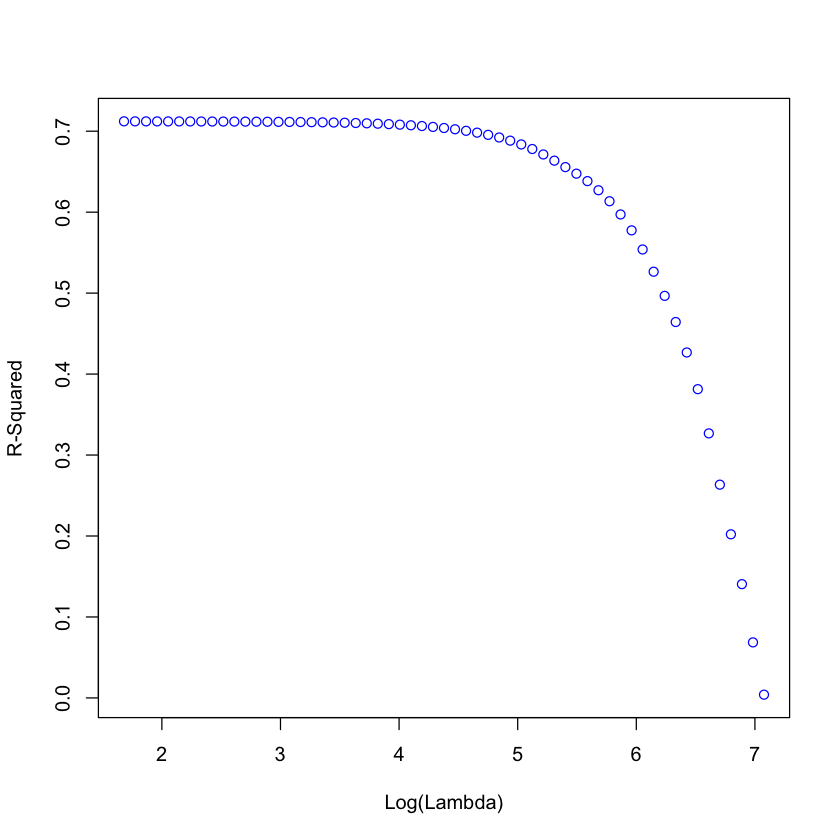

In [13]:
# Set seed for replication
set.seed(555)

# Function to calculate the cross-validation errors for all lambda
cv_lasso <- cv.glmnet(x_train, y_train, alpha=1, nfolds=10)

# Calculate the r-squared of the model for each lambda 
r2 <- 1 - cv_lasso$cvm/var(y_train) 

# Plots log(lambda) and R2
plot(log(cv_lasso$lambda), r2, xlab="Log(Lambda)", ylab="R-Squared", col="Blue")

In [14]:
print("max R^2:")
max(r2)
best_lambda <- cv_lasso$lambda[which(r2==max(r2))] 
print("Optimal Lambda")
best_lambda

[1] "max R^2:"


[1] 0.7121878

[1] "Optimal Lambda"


[1] 5.36923

Show the coefficients of the Lasso model with the optimal lambda. (Hint: use the ``coef()`` command with the options ``s = best_lambda, exact = TRUE, x=x_train, y=y_train``, where ``best_lambda`` is a variable that stores the optimal lamda, ``x_train`` is the matrix of covariates used to estimate the model, ``y_train`` is the vector of outcome variable used in the estimation. If you use different names that's OK!)

In [15]:
lasso_coef <- predict(lasso_train, type="coefficients", s=best_lambda, exact = TRUE, x=x_train, y=y_train)
lasso_coef

5 x 1 sparse Matrix of class "dgCMatrix"
                   s1
(Intercept) -896.4651
carat       7134.7953
clarity      526.5371
high_color  1267.6640
cut          381.7431

Calculate the Lasso in-sample prediction performance indicator $R^2$ using the optimal lambda. To do this, you have to generate a prediction of the outcome variable using the Lasso model and the training dataset.

In [16]:
lasso_predict_in <- predict(lasso_train, s=best_lambda, newx = x_train)
# Calculate r-square for lasso
print('In-sample R-squared')
1-mean((lasso_predict_in-y_train)^2)/var(y_train) 

[1] "In-sample R-squared"


[1] 0.7296979

Calculate the Lasso out-of-sample prediction performance indicator $R^2$. To do this, you have to generate a prediction of the outcome variable using the Lasso model and the test dataset.

In [17]:
lasso_predict_out <- predict(lasso_train, s=best_lambda, newx = x_test)
print('Out-of-sample R-squared')
1-mean((lasso_predict_out-y_test)^2)/var(y_test) 

[1] "Out-of-sample R-squared"


[1] 0.7043503

## Question 3: OLS 
Recall from lecture that Lasso models belong to the family of linear models. Ordinary Least Squares (OLS), which we worked with last week is another type of linear model. OLS is the best linear unbiased estimator (BLUE), the coefficients we get from running OLS is an unbiased estimate of the true linear relationship. Lasso differ from OLS by introducing bias into the estimates but reducing variance in the estimates to overall offer better prediction accuracy.  

Estimate an OLS regression on the training dataset (same predictors and outcome). You can do this in the same way you estimated the Lasso model, but this time setting lambda to 0 (``lambda=0``) instead of the optimal lambda. 

In [22]:
# Run OLS with selected lambda on test set, get r-square for both
ols <- predict(ols_train, type="coefficients", s=0, exact=T, x=x, y=y)
ols

ols_train <- glmnet(x_train, y_train, alpha=1, lambda=0)

5 x 1 sparse Matrix of class "dgCMatrix"
                   s1
(Intercept) -926.5577
carat       7172.2602
clarity      538.7063
high_color  1282.9907
cut          377.9646

Calculate the OLS in-sample prediction performance indicator $R^2$. To do this, you have to generate a prediction of the outcome variable using the OLS model and the training dataset.

In [19]:
ols_predict_in <- predict(ols_train, s=0, newx = x_train)
# Calculate r-square for OLS
print('In-sample R-squared')
1-mean((ols_predict_in-y_train)^2)/var(y_train) 


[1] "In-sample R-squared"


[1] 0.7297304

Calculate the OLS out-of-sample prediction performance indicator $R^2$. To do this, you have to generate a prediction of the outcome variable using the Lasso model and the test dataset.

In [20]:
ols_predict_out <- predict(ols_train, s=0, newx = x_test)
print('Out-of-sample R-squared')
1-mean((ols_predict_out-y_test)^2)/var(y_test) 

[1] "Out-of-sample R-squared"


[1] 0.7031702

Which model has a better performance in-sample?

Which model has a better performance out-of-sample?

In [21]:
print("OLS is better in-sample, Lasso is better out-of-sample")

[1] "OLS is better in-sample, Lasso is better out-of-sample"
